In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import cv2
from skimage.measure import find_contours
from shapely.geometry import Polygon

# Define the DataGenerator class to load and preprocess data in batches
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_files, mask_files, batch_size, target_image_size):
        self.image_files = image_files
        self.mask_files = mask_files
        self.batch_size = batch_size
        self.target_image_size = target_image_size

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def __getitem__(self, index):
        batch_image_files = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_files = self.mask_files[index * self.batch_size:(index + 1) * self.batch_size]

        batch_images = []
        batch_masks = []

        for img_file, mask_file in zip(batch_image_files, batch_mask_files):
            img_path = os.path.join(image_folder, img_file)
            mask_path = os.path.join(mask_folder, mask_file)

            img = preprocess_image(img_path)
            mask = preprocess_mask(mask_path)

            batch_images.append(img)
            batch_masks.append(mask)

        batch_images = np.array(batch_images)
        batch_masks = np.array(batch_masks)

        return batch_images, batch_masks

# U-Net model
def unet_model(input_shape):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)

    up4 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv3)
    up4 = concatenate([up4, conv2])
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv1])
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(conv5)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Preprocessing functions
def preprocess_image(img_path):
    img = Image.open(img_path)
    img = img.resize(target_image_size)  # Resize to target size
    img = np.array(img) / 255.0  # Normalize pixel values [0, 1]
    return img

def preprocess_mask(mask_path):
    mask = Image.open(mask_path)
    mask = mask.resize(target_image_size)  # Resize to target size
    mask = np.array(mask)
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    mask = mask / 255.0  # Normalize pixel values [0, 1]
    return mask

# Set your image and mask folders
image_folder = r"C:/Users/nalin/Downloads/archive2/train/image"
mask_folder = r"C:/Users/nalin/Downloads/archive2/train/label"

# List image and mask files
image_files = os.listdir(image_folder)
mask_files = os.listdir(mask_folder)

# Set the target image size
target_image_size = (256, 256)

# Define the input shape
input_shape = target_image_size + (3,)  # 3 channels (RGB)

In [3]:
# Create the model
model = unet_model(input_shape)
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    """
    Learning rate schedule function.
    """
    learning_rate = 1e-3  # Initial learning rate

    if epoch > 10:
        learning_rate *= 0.1
    elif epoch > 5:
        learning_rate *= 0.5

    return learning_rate
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Create the data generator
train_data_generator = DataGenerator(image_files, mask_files, batch_size=40, target_image_size=target_image_size)

# Training
model.fit(train_data_generator, steps_per_epoch=len(train_data_generator), epochs=4, callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/4
21/21 [==============================] - 210s 10s/step - loss: 0.3371 - accuracy: 0.8699 - lr: 0.0010
Epoch 2/4
21/21 [==============================] - 254s 12s/step - loss: 0.2204 - accuracy: 0.8998 - lr: 0.0010
Epoch 3/4
21/21 [==============================] - 226s 11s/step - loss: 0.1647 - accuracy: 0.8998 - lr: 0.0010
Epoch 4/4
21/21 [==============================] - 218s 10s/step - loss: 0.1682 - accuracy: 0.8998 - lr: 0.0010


1/1 [==============================] - 0s 306ms/step


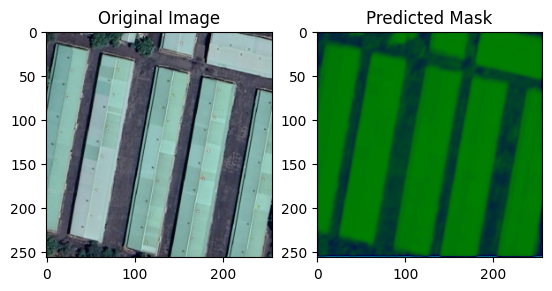

In [4]:
# Sample image for prediction
sample_image_path = r"C:/Users/nalin/Downloads/file.tif"
sample_image = preprocess_image(sample_image_path)
sample_image = np.expand_dims(sample_image, axis=0)

# Predict
predicted_mask = model.predict(sample_image)
predicted_mask = np.squeeze(predicted_mask)

# Display original image and predicted mask
plt.subplot(1, 2, 1)
plt.imshow(sample_image[0])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap="ocean")
plt.title('Predicted Mask')

plt.show()

1/1 [==============================] - 0s 71ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


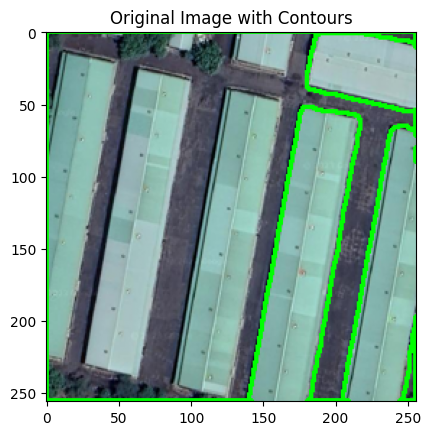

In [5]:
# Predict
predicted_mask = model.predict(sample_image)
predicted_mask = np.squeeze(predicted_mask)

# Threshold the predicted mask
threshold = 0.042
# Adjust this threshold as needed
binary_mask = (predicted_mask > threshold).astype(np.uint8)

# Apply morphological operations to the binary mask
kernel = np.ones((4, 4), np.uint8)
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

# Find contours in the binary mask
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
contour_image = sample_image[0].copy()  # Make a copy of the original image
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Draw green contours

# Display the original image with marked contours
plt.imshow(contour_image)
plt.title('Original Image with Contours')
plt.show()

In [6]:
from shapely.geometry import Polygon
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image =  contour_image
#image = cv2.imread(image_path)
image = cv2.convertScaleAbs(image)
# Check if the image was loaded successfully
if image is None:
    print("Failed to load the image")
    exit()

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Convert the grayscale image to a supported depth
gray = cv2.convertScaleAbs(gray)

# Apply edge detection
edges = cv2.Canny(gray, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Approximate contours to polygons using the Ramer-Douglas-Peucker algorithm
polygons = []
for contour in contours:
    epsilon = 0.04 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    if len(approx) >= 4:  # Check if the polygon has at least 4 vertices
        polygon = Polygon([point[0] for point in approx])
        polygons.append(polygon)

# Display the detected polygons
for polygon in polygons:
    print(polygon)

POLYGON ((254 79, 253 89, 255 91, 253 89, 254 79))
POLYGON ((187 5, 253 9, 191 2, 181 35, 255 52, 184 39, 187 5))
POLYGON ((231 2, 252 1, 252 5, 242 4, 253 5, 252 1, 231 2))
POLYGON ((3 1, 1 252, 138 253, 184 50, 203 253, 253 57, 3 1))
POLYGON ((3 1, 253 57, 202 253, 184 50, 138 252, 1 252, 3 1))


In [7]:
import geopandas as gpd
from shapely.geometry import Polygon

polygon_geometries = []

for polygon in polygons:
    polygon_geometries.append(polygon)

geo_series = gpd.GeoSeries(polygon_geometries)

gdf = gpd.GeoDataFrame(geometry=geo_series)

gdf.crs = 'EPSG:4326'

In [8]:
gdf

,geometry
0,"POLYGON ((254.00000 79.00000, 253.00000 89.000..."
1,"POLYGON ((187.00000 5.00000, 253.00000 9.00000..."
2,"POLYGON ((231.00000 2.00000, 252.00000 1.00000..."
3,"POLYGON ((3.00000 1.00000, 1.00000 252.00000, ..."
4,"POLYGON ((3.00000 1.00000, 253.00000 57.00000,..."


In [9]:
"""import cv2
import matplotlib.pyplot as plt

# ... (your existing code to create contour_image)

# Save the contour image as a TIFF file
output_file_path = "C:/Users/nalin/Downloads/output_image_with_contours5.tif"  # Specify the desired file path
cv2.imwrite(output_file_path, contour_image)

# Display the saved image
plt.imshow(contour_image)
plt.title('Original Image with Contours')
plt.show()

print(f"Contour image saved as '{output_file_path}'")
"""


'import cv2\nimport matplotlib.pyplot as plt\n\n# ... (your existing code to create contour_image)\n\n# Save the contour image as a TIFF file\noutput_file_path = "C:/Users/nalin/Downloads/output_image_with_contours5.tif"  # Specify the desired file path\ncv2.imwrite(output_file_path, contour_image)\n\n# Display the saved image\nplt.imshow(contour_image)\nplt.title(\'Original Image with Contours\')\nplt.show()\n\nprint(f"Contour image saved as \'{output_file_path}\'")\n'

In [11]:
import geopandas as gpd
import rasterio
import numpy as np
import pyproj

# Specify the path to your preprocessed raster image
raster_file_path = r"C:/Users/nalin/Downloads/file.tif"

with rasterio.open(raster_file_path) as src:
    transform = src.transform

    lon_coords = []
    lat_coords = []

    # Assuming you have a GeoDataFrame 'gdf' defined elsewhere in your code

    max_vertices = max(len(geom.exterior.coords) for geom in gdf['geometry'])

    for geom in gdf['geometry']:
        polygon_points = list(geom.exterior.coords)

        while len(polygon_points) < max_vertices:
            polygon_points.append(polygon_points[0])

        lon, lat = zip(*[transform * p for p in polygon_points])
        
        transformer = pyproj.Transformer.from_crs(src.crs, 'EPSG:4326', always_xy=True)

        lon, lat = transformer.transform(lon, lat)

        lon_coords.append(lon)
        lat_coords.append(lat)

    lon_array = np.column_stack(lon_coords)
    lat_array = np.column_stack(lat_coords)

    np.set_printoptions(threshold=np.inf)

    # Print the results
    print(f"Longitude:\n{lon_array}")
    print(f"Latitude:\n{lat_array}")


Longitude:
[[79.075092   79.07491754 79.07503211 79.07443843 79.07443843]
 [79.0750894  79.0750894  79.07508679 79.07443322 79.0750894 ]
 [79.0750946  79.07492796 79.07508679 79.07478995 79.0749566 ]
 [79.0750894  79.07490192 79.07506075 79.07490973 79.07490973]
 [79.075092   79.0750946  79.0750894  79.0749592  79.07478995]
 [79.075092   79.07490973 79.07508679 79.0750894  79.07443322]
 [79.075092   79.07491754 79.07503211 79.07443843 79.07443843]]
Latitude:
[[21.11677131 21.11696399 21.11697181 21.11697441 21.11697441]
 [21.11674527 21.11695358 21.11697441 21.11632084 21.11682859]
 [21.11674006 21.11697181 21.11696399 21.11631823 21.11631823]
 [21.11674527 21.11688588 21.1169666  21.11684682 21.11684682]
 [21.11677131 21.11684161 21.11696399 21.11631823 21.11632084]
 [21.11677131 21.11687546 21.11697441 21.11682859 21.11632084]
 [21.11677131 21.11696399 21.11697181 21.11697441 21.11697441]]


In [12]:
print(gdf.crs)

EPSG:4326


In [13]:
import geopandas as gpd
from shapely.geometry import Polygon
# Create a list of Polygon objects from the coordinates
polygons = [Polygon(zip(lon_array[i], lat_array[i])) for i in range(len(lon_array))]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polygons, crs='EPSG:4326')

# Save the GeoDataFrame to a GeoJSON file
output_geojson_file = r"C:/Users/nalin/Downloads/qwerty.geojson"
gdf.to_file(output_geojson_file, driver='GeoJSON')

print(f"Coordinates saved to {output_geojson_file}")
print(gdf.crs)

Coordinates saved to C:/Users/nalin/Downloads/qwerty.geojson
EPSG:4326
